- Gruppo:
    - Luca Ninivaggi 5312342
    - Flavio Barrara Stefani 5175710
- Dataset:
    Video Games



# <b style="color:tomato;"> OPERAZIONI PRELIMINARI </b>

## <p style="color:powderblue;"> IMPORT & FUNZIONI </p>

Sono di seguito riportati i segmenti che contengono le librerie necessarie e le porzioni di codice utilizzate molteplici volte.

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency
from matplotlib.ticker import ScalarFormatter
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import imageio
from IPython.display import Image
import os


In [20]:
# completa la colonnna mancante di una tupla se ne esiste un'altra con lo stesso nome e suddetta colonna indicata
def complete_column_with_same_name(dataset,column):
  # prendo gli indici sulle colonne
  name_id = dataset.columns.get_loc('Name')
  column_id = dataset.columns.get_loc(column)

  # itero sulle righe da completare
  for inc_id in np.where(dataset[column].isnull())[0] :
    # nome della tupla studiata
    inc_name = dataset.iloc[inc_id,name_id]
    # prendo un array di tuple che hanno lo stesso nome e hanno la colonna non null
    finded_index_array = np.where((dataset['Name'] == inc_name) & dataset[column].notnull())[0] #array di indici con lo stesso nome
    # se non ho trovato tuple, passo alla prossima
    if finded_index_array.size == 0: continue
    # prendo l'indice della prima tupla
    finded_index = finded_index_array[0]
    # aggiorno la tupla da completare
    dataset.iloc[inc_id,column_id] = dataset.iloc[finded_index,column_id]

In [21]:
def create_map(values):
    return {val: index for index, val in enumerate(values)}


def create_OLAP(grouped_dataset,x_labels,y_labels,z_labels):
    # creazione della mappa per gli anni
    x_map = create_map(x_labels)
    # creazione della mappa per i publisher
    y_map = create_map(y_labels)
    # creazione della mappa per le piattaforme
    z_map = create_map(z_labels)

    # inizializziamo la matrice OLAP con zeri
    OLAP = np.zeros((len(x_map), len(y_map), len(z_map))).astype(int)
    for i, row in grouped_dataset.iterrows():
        x = x_map[grouped_dataset.iloc[i, 0]]
        y = y_map[grouped_dataset.iloc[i, 1]]
        z = z_map[grouped_dataset.iloc[i, 2]]
        OLAP[x,y,z] = row['Count']
    return OLAP,x_map,y_map,z_map

# crea una matrice publisher X platform
def create_reduced_OLAP(OLAP,year_labels):
    reduced_OLAP = np.full(OLAP.shape[1:], np.nan) # faccio una matrice vuota publisher X platform
    for y in range(OLAP.shape[1]):     # iterazione su y (publisher)
        for z in range(OLAP.shape[2]): # iterazione su z (platform)
            # calcolo l'anno medio lungo x
            sum_value = 0
            tot_values = 0
            for x in range(OLAP.shape[0]):        # iterazione su x (anni)
                sum_value += OLAP[x,y,z]*year_labels[x]
                tot_values += OLAP[x,y,z]
            if tot_values > 0: # se la media esiste (la riga non era tutta 0)
                reduced_OLAP[y,z] = sum_value / tot_values
    return reduced_OLAP           

def complete_with_reduced_OLAP(dataset,reduced_OLAP,column_incompleted,row_labels_name,row_map,column_labels_name,column_map):
    id_column = dataset.columns.get_loc(column_incompleted)
    missing_ids = np.where(dataset[column_incompleted].isnull())[0]

    for idx in missing_ids:
        row_label = dataset.iloc[idx][row_labels_name]
        column_label = dataset.iloc[idx][column_labels_name]
        value = reduced_OLAP[row_map[row_label],column_map[column_label]]
        if not np.isnan(value):
            dataset.iloc[idx,id_column] = value

In [22]:
def draw_sales_profile(dataset,region,column,min_year = None,max_year= None,resize_y= False,min_y=0,max_y=200,position=(1,1,1),title=None):
    if (min_year is None): min_year =dataset['Year_of_Release'].min()
    if (max_year is None): max_year = dataset['Year_of_Release'].max()
    years = list(range(min_year,max_year+1))
    
    grouped_dataset = dataset.groupby([column,'Year_of_Release'])[region].sum()
    sales_by_year = grouped_dataset.groupby('Year_of_Release').sum()
    if (column == 'Publisher'):
        column_values = dataset.groupby(column)['Year_of_Release'].count().sort_values(ascending=False)
    else:
        column_values = dataset.groupby(column)['Year_of_Release'].mean().sort_values()
    colors = sns.color_palette('colorblind',n_colors=len(column_values))

    plt.subplot(position[0],position[1],position[2])
    plt.plot(sales_by_year.index, sales_by_year.values, color='black', label='_nolegend_')

    legend = []
    cumulative_sales = 0
    for i,value in enumerate(column_values.index):        
        sales_by_column = grouped_dataset.loc[value].reindex(years, fill_value=0)
        plt.fill_between(sales_by_year.index, cumulative_sales, cumulative_sales+sales_by_column, label=value ,color=colors[i])
        cumulative_sales += sales_by_column
        legend.append((value,colors[i]))

    plt.ylabel('Copie vendute (mln)')
    if title is not None: plt.title(title)
    plt.grid(True)
    if (resize_y): plt.ylim(min_y, max_y)
    
    return legend
    
def show_legend(ax, n=15, col=1, box_to_anchor=(-0.3, 1.8)):
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[:n*col], labels[:n*col], loc='upper left', bbox_to_anchor=box_to_anchor, ncol=col)

In [23]:
def save_plot_images(dataset,genre_labels,platform_labels,publisher_labels,plot_type,palette=None,min_year= None,max_year=None): 
    if (min_year is None): min_year = dataset['Year_of_Release'].min()
    if (max_year is None): max_year = dataset['Year_of_Release'].max()
    years = list(range(min_year,max_year+1))
    
    genre_map = create_map(genre_labels)
    platform_map = create_map(platform_labels)
    publisher_map = create_map(publisher_labels)
    # creo la cartella eventualemente
    output_path=str(plot_type)+"/" 
    if not os.path.exists(output_path):
        os.makedirs(output_path) 
        
    for year in years:
        # inizializzo il grafico
        fig = plt.figure(figsize=[8,8])
        ax = fig.add_subplot(111, projection='3d')
        
        # estraggo le tuple dell'anno corrente
        tuples = dataset.iloc[np.where(dataset['Year_of_Release'] == year)[0]]
        
        # cambia come calcolo i colori
        colors = []
        
        if (plot_type=='regression'):
            tot_points = len(tuples)
            Wrong_points = JP_points = EU_points = 0
            for _,row in tuples.iterrows():
                if row['Prediction'] != row['JP_better']:
                    Wrong_points += 1
                    colors.append('red')
                elif row['JP_better'] == 1:
                    JP_points += 1
                    colors.append('green')
                else:
                    EU_points += 1
                    colors.append('blue')
                    
            ax.text2D(0, 0.05, f'JP guessed points: {JP_points/tot_points*100:.2f}%',       transform=plt.gca().transAxes, fontsize=10,color='green')
            ax.text2D(0, 0,    f'EU guessed Points: {EU_points/tot_points*100:.2f}%',       transform=plt.gca().transAxes, fontsize=10,color='blue')
            ax.text2D(0, -0.05,f'Wrong Points: {Wrong_points/tot_points*100:.2f}%', transform=plt.gca().transAxes, fontsize=10,color='red')
        else: # clustering
            for _,row in tuples.iterrows():
                colors.append(palette[row['Cluster_number']])
             
        # torno in coordinate intere   
        ax.scatter([genre_map[v] for v in tuples['Genre']], [platform_map[v] for v in tuples['Platform']], [publisher_map[v] for v in tuples['Publisher']], alpha=1, c=colors)
       
        # titolo del grafico
        plt.title(f'3D Plot for Year {year}')   
                              
        ax.set_xlim(0, len(genre_map))  
        ax.set_ylim(0, len(platform_map))  
        ax.set_zlim(0, len(publisher_map))  
        
        # abilita tutte le etichette degli assi
        ax.set_xticks(range(len(genre_labels)))
        ax.set_yticks(range(len(platform_labels)))
        ax.set_zticks([]); ax.set_zlabel('Publisher')

        # associa a ciascuna etichetta una linea sottile grigia
        ax.xaxis.grid(True, linestyle='-', color='lightgrey')
        ax.yaxis.grid(True, linestyle='-', color='lightgrey')

        # imposta le etichette sugli assi
        ax.set_xticklabels(genre_labels,fontsize=10)
        ax.set_yticklabels([platform_labels[i] if i %2 == 0 else '' for i in  range(len(platform_labels))],fontsize=8)
        ax.view_init(elev=25, azim=330)  # modifica i valori di elev e azim secondo le tue esigenze

        # salvataggio del grafico come immagine
        plt.savefig(f"{output_path}plot_{year}.png")
        # chiusura del plot
        plt.close()      
        
    images = []
    for year in years: images.append(imageio.imread(f"{output_path}plot_{year}.png"))
    return images

def myKmeans(dataset, k, max_iterations):
    # inizializzazione dei centroidi
    centroids = dataset.sample(n=k)
    centroids = centroids.reset_index(drop=True)
    
    # inizializzazione dei cluster
    clusters = np.zeros(len(dataset))
    
    # iterazione sul numero massimo di iterazioni
    for _ in range(max_iterations):
        # calcolo della distanza tra ciascuna tupla e i centroidi
        distances = np.zeros((len(dataset), k))
        for i in range(k):
            distances[:,i] = np.linalg.norm(dataset - centroids.iloc[i], axis=1)
        
        # assegnazione delle tuple ai cluster
        new_clusters = np.argmin(distances, axis=1)
        
        # se i cluster non cambiano, interrompiamo
        if np.array_equal(clusters, new_clusters):
            break
        clusters = new_clusters
        
        # calcolo dei nuovi centroidi
        for i in range(k):
            centroids.iloc[i] = dataset[clusters == i].mean()
    
    return clusters, centroids

## <p style="color:powderblue;"> OVERVIEW DEL DATASET </p>

Iniziamo caricando il dataset e visualizzandone il contenuto.

In [24]:
dataset = pd.read_csv("Video_Games.csv")
dataset.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


Osserviamo che abbiamo una grande quantitá di valori null all'interno del dataset:

In [25]:
na_percentuals = dataset.isna().mean() * 100
print(f"Percentuali di valori mancanti per ogni colonna: \n{na_percentuals.round(2)}")

Percentuali di valori mancanti per ogni colonna: 
Name                0.01
Platform            0.00
Year_of_Release     1.61
Genre               0.01
Publisher           0.32
NA_Sales            0.00
EU_Sales            0.00
JP_Sales            0.00
Other_Sales         0.00
Global_Sales        0.00
Critic_Score       51.33
Critic_Count       51.33
User_Score         40.10
User_Count         54.60
Developer          39.61
Rating             40.49
dtype: float64


## <p style="color:powderblue;"> DATA CLEANING </p>
Proviamo a colmare i valori vuoti, e in casi disperati andiamo a cancellare le tuple/colonne "irrecuperabili".

### <p style="color:lightgreen;"> GENERALE </p>

Innanzitutto rimuoviamo le tuple senza il nome indicato, poiché la mancanza di tale dato potrebbe significare che tutti i valori sono compromessi (effettivamente, le uniche 2 tuple senza Genre sono proprio quelle senza Name).

In [26]:
original_len = len(dataset)
dataset = dataset.dropna(subset=['Name'])

print(f"removed {original_len-len(dataset)} tuples")

removed 2 tuples


Data l'estrema eterogeneitá della colonna 'Developer', eventuali studi sono impossibili o comunque porterebbero a risultati poco attendibili, andiamo quindi a eliminarla.

Eliminiamo anche le colonne 'Critic_Count', 'Critic_Score', 'User_Score' e 'User_Count' a causa delle scarse informazioni, aventi più della metá delle volte un valore non definito.

In [27]:
dataset = dataset.drop(columns=['Developer','Critic_Score','Critic_Count','User_Score','User_Count'])

Infine, osservando il database notiamo che alcune tuple sono con valori "errati", in particolare ne abbiamo individuate 2.

In [28]:
bugged_ids = np.where(dataset['Name'].isin(["Imagine: Makeup Artist","Strongest Tokyo University Shogi DS"]))[0]
dataset.iloc[bugged_ids]

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Rating
5936,Imagine: Makeup Artist,DS,2020.0,Simulation,Ubisoft,0.27,0.0,0.00,0.02,0.29,E
15959,Strongest Tokyo University Shogi DS,DS,1985.0,Action,Mycom,0.00,0.0,0.02,0.00,0.02,NaN


La prima tupla ha come anno il valore 2020, e questo non è possibile poichè il dataset è stato assemblato con dati osservati dal 1985 al 2017, e perciò qualsiasi valore successivo è da considerarsi errato.

Per quanto riguarda la seconda tupla, non è possibile sia valida in quanto il Nintendo DS è stato presentato nel 2009.

Andiamo quindi a eliminarle.

In [29]:
original_len = len(dataset)
dataset = dataset.drop(dataset.index[bugged_ids])

print(f"Removed {original_len-len(dataset)} tuples")

Removed 2 tuples


Eliminiamo infine anche le tuple con anno 2017: sicuramente i dati sulle vendite saranno "compromessi" dalla ridottisma fascia temporale in cui possono essere stati acquistati.

In [30]:

original_len = len(dataset)
drop_ids = np.where(dataset['Year_of_Release'] >= 2017)[0]
dataset = dataset.drop(dataset.index[drop_ids])

print(f"Removed {original_len-len(dataset)} tuples")

Removed 3 tuples


Ora che abbiamo rimosso le tuple e le colonne inutilizzabili, iniziamo con lo studio dei dati null per cercare di completarli nel modo piú corretto possibile.

### <p style="color:lightgreen;"> PUBLISHER </p>

Iniziamo andando a osservare il numero di valori null, che peró non rappresenta in modo reale l'integritá della colonna: infatti abbiamo un altro valore, "Unknown", utilizzato come placeholder.

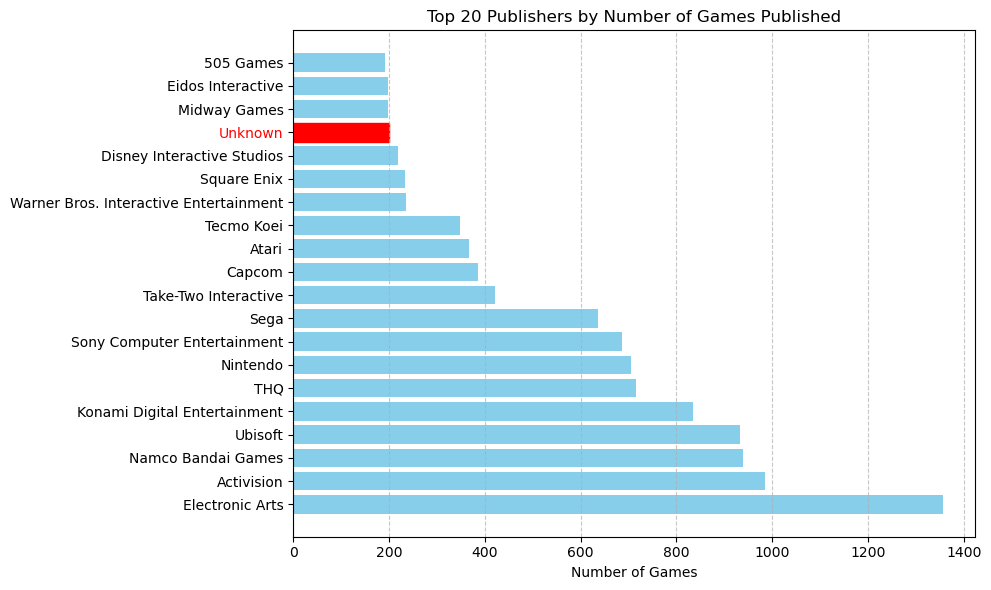

In [31]:
N_publisher = 20

# prendo i top N publisher
publisher_counts = dataset['Publisher'].value_counts()
top_publishers = publisher_counts.head(N_publisher)

plt.figure(figsize=(10, 6))
bars = plt.barh(y=top_publishers.index, width=top_publishers.values,color= 'skyblue')

# coloro la barra e l'etichetta per "Unknown" di verde
unknown_index = top_publishers.index.get_loc("Unknown")
bars[unknown_index].set_color('red')
plt.gca().get_yticklabels()[unknown_index].set_color('red')

plt.title(f"Top {N_publisher} Publishers by Number of Games Published")
plt.xlabel("Number of Games")
plt.grid(axis='x', linestyle='--', alpha=0.7)  # griglia sull'asse x
plt.tight_layout()
plt.show()

Rimuoviamo le tuple con Publisher "Unknown" oppure null, dato che non abbiamo modo di inferire questa informazione dai restanti valori nel dataset.

In [32]:
original_len = len(dataset)
drop_ids = np.where((dataset['Publisher'] == "Unknown") | (dataset['Publisher'].isnull()))[0]
dataset = dataset.drop(dataset.index[drop_ids])

print(f"Removed {original_len-len(dataset)} tuples")


Removed 255 tuples


### <p style="color:lightgreen;"> YEAR_OF_RELEASE </p>

Notiamo di avere pochi valori mancanti, possiamo quindi provare a trarre questa informazione dai dati forniti.

In [33]:
print(f"Tuple with null as Year_of_Release: {dataset['Year_of_Release'].isnull().sum()}")

Tuple with null as Year_of_Release: 145


Supponendo che un gioco sia uscito per diverse piattaforme circa nello stesso anno, cerchiamo per ogni tupla incompleta se nel dataset esiste lo stesso videogioco (ovvero con lo stesso nome) ma con anno di rilascio specificato, e lo copiamo.

In [34]:
null_count_before = dataset['Year_of_Release'].isnull().sum()

complete_column_with_same_name(dataset,'Year_of_Release')

print(f"Tuples fixed: {null_count_before-dataset['Year_of_Release'].isnull().sum()}")

Tuples fixed: 74


Questo procedimento ha avuto i suoi  effetti positivi, ma non basta: attuiamo allora un altra tecnica.

Osserviamo ora come i dati forniti ci dicano come i giochi vengono prodotti per una data console in un lasso di tempo limitato: con un box plot visualizziamo come sono sparsi questi valori.

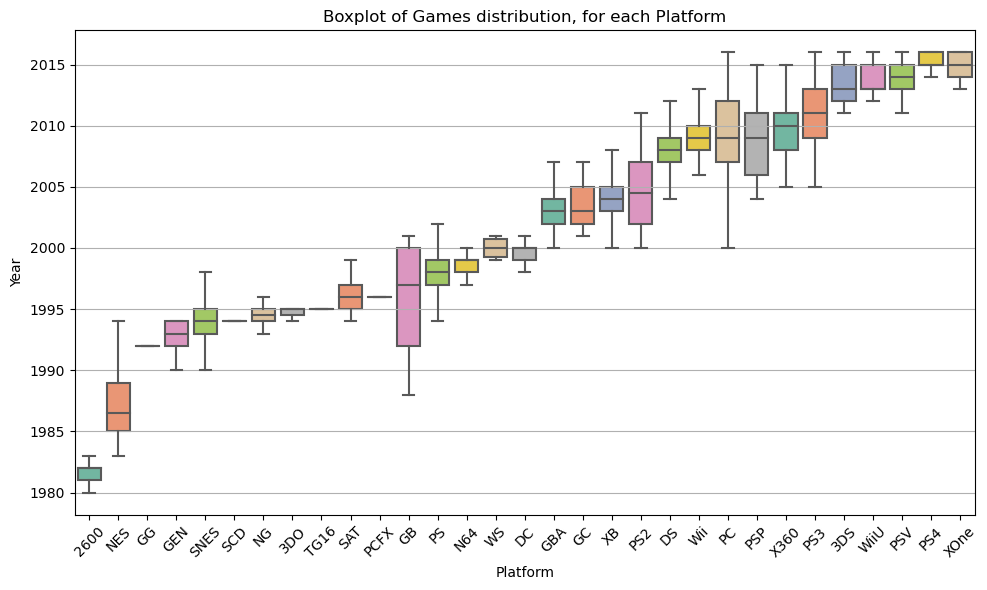

In [35]:
#ordino le piattaforme in base alla loro mediana di anno 
platforms_mean = dataset.groupby('Platform')['Year_of_Release'].median().sort_values()
platforms_ids = platforms_mean.index

# Crea il boxplot con le piattaforme ordinate in base alla mediana
plt.figure(figsize=(10, 6))
sns.boxplot(data=dataset, y='Year_of_Release', x='Platform', order=platforms_ids, palette='Set2',showfliers=False)
plt.title("Boxplot of Games distribution, for each Platform")
plt.xlabel('Platform')
plt.ylabel('Year')
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Per alcune piattaforme, il lasso di tempo é ovviamente piú lungo: ad esempio GameBoy (GB), che ha avuto successo per molti anni oppure il PC, che é in commercio dai primi anni 2000.

Dimostriamo anche in modo empirico che le piattaforme GG, PCFX e TG16 hanno una "dispersione" sugli anni limitata poiché nel nostro dataset i giochi di tali piattaforme sono pochissimi, e il loro mercato é assolutamente non rilevante ai fini degli studi statistici. 

Procediamo eliminando tali tuple.

In [36]:
platforms_removed = ['GG','PCFX','TG16']

original_len = len(dataset)
drop_ids = dataset['Platform'].isin(platforms_removed)

table = dataset[drop_ids].groupby('Platform').agg(total_tuples=('Platform', 'size'),Total_Global_Sales=('Global_Sales', 'sum')).reset_index()
print(table)

dataset = dataset.drop(dataset.index[drop_ids])

print(f"Removed {original_len-len(dataset)} tuples")

  Platform  total_tuples  Total_Global_Sales
0       GG             1                0.04
1     PCFX             1                0.03
2     TG16             2                0.16
Removed 4 tuples


A questo punto abbiamo osservato come, data una piattaforma, la distribuzione lungo gli anni sia di tipo modale: ovvero tutti i giochi per una piattaforma tendono ad avere un "periodo di produzione" limitato.

Usiamo questa osservazione per poter completare le tuple il cui anno di uscita non è indicato: creiamo un <b style="color:orange">OLAP</b> avente sugli assi ['Year_of_Release', 'Publisher','Platform'] e in ogni cella il relativo count delle tuple.


In [37]:
# creo delle mappe da indice a stringa
year_labels = dataset['Year_of_Release'].dropna().sort_values(ascending=False).unique().astype(int)
publisher_labels = dataset.groupby('Publisher').size().sort_values(ascending=False).index.to_numpy() # publisher dal più al meno produttivo
platform_labels = dataset.groupby('Platform')['Year_of_Release'].mean().sort_values().index.to_numpy() # piattaforme dalla più alla meno recente (media di tutti i giochi usciti)

grouped_data = dataset.groupby(['Year_of_Release', 'Publisher','Platform']).size().reset_index(name='Count')

# mi restituiscono mappe da stringa a indice
OLAP,year_map,publisher_map,platform_map = create_OLAP(grouped_data,year_labels,publisher_labels,platform_labels)

In [38]:
# calcola la media lungo l'asse degli anni per ottenere una tabella ridotta publisher X platform
reduced_OLAP = create_reduced_OLAP(OLAP,year_labels)

Facciamo ora SLICING per estrarre ad esempio il layer del publisher "Electronic Arts", notiamo come tutti i giochi prodotti da quella piattaforma siano "vicini" dal punto di vista temporale (ovvero c'è varianza bassa).

Indichiamo inoltre con un pallino rosso l'anno medio di uscita per ogni piattaforma.

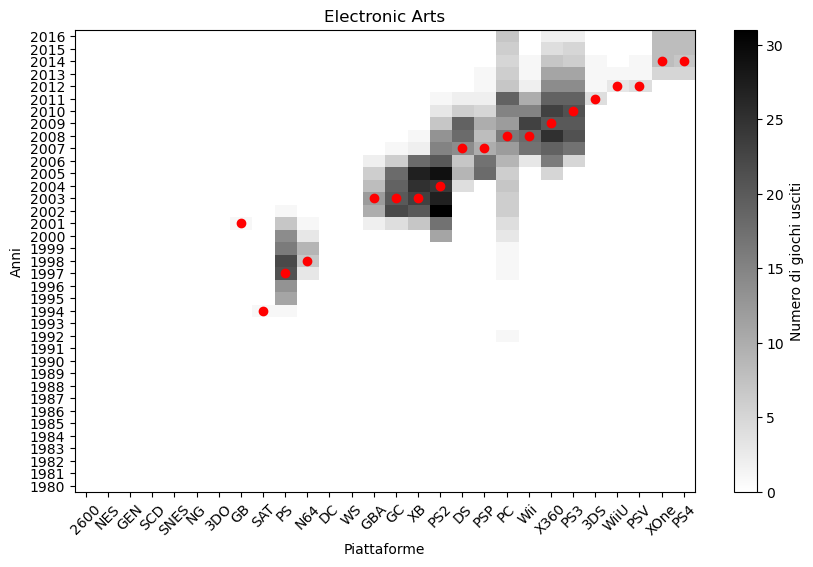

In [39]:
publisher_name = 'Electronic Arts'
publisher_id = publisher_map[publisher_name]
sliced_OLAP = OLAP[:,publisher_id,:]

# Creazione della heatmap
plt.figure(figsize=(10, 6))
for _,platform_id in platform_map.items():
    year_id = reduced_OLAP[publisher_id,platform_id]
    if (np.isnan(year_id)): continue
    median = year_map[int(year_id)]
    plt.scatter(platform_id,median,color='red',alpha=1)

# Etichette degli assi
plt.xlabel('Piattaforme')
plt.ylabel('Anni')
plt.title(publisher_name)

plt.imshow(sliced_OLAP, cmap='gray_r', aspect='auto')
plt.colorbar(label='Numero di giochi usciti')

# Aggiunta delle etichette delle piattaforme e degli anni
plt.xticks(range(len(platform_labels)), platform_labels, rotation=45)
plt.yticks(range(len(year_labels)), year_labels)


plt.show()

Mostriamo che anche gli altri slice hanno la stessa proprietà.

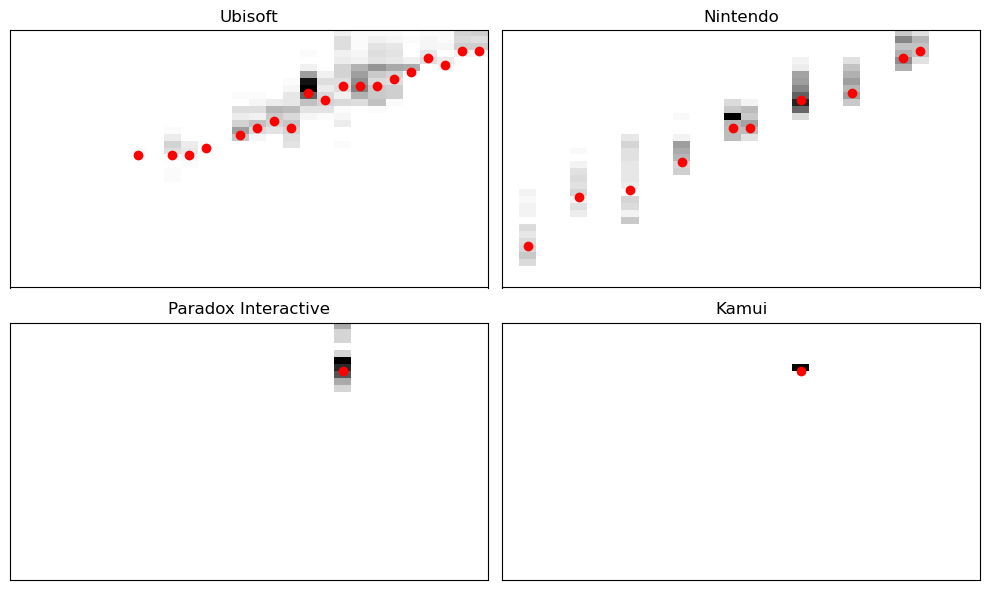

In [40]:
# seleziono quattro indici diversi
publisher_names = ['Ubisoft', 'Nintendo', 'Paradox Interactive', 'Kamui']

fig, axs = plt.subplots(2, 2, figsize=(10, 6))

# itero sui subplots e sugli indici
for i, ax in enumerate(axs.flat):
    publisher_name = publisher_names[i]
    publisher_id = publisher_map[publisher_name]
    sliced_OLAP = OLAP[:,publisher_id,:]
    
    for _,platform_id in platform_map.items():
        year_id = reduced_OLAP[publisher_id,platform_id]
        if (np.isnan(year_id)): continue
        median = year_map[int(year_id)]
        ax.scatter(platform_id,median+0.5,color='red',alpha=1)

    # etichette degli assi
    ax.set_title(publisher_name)
    ax.imshow(sliced_OLAP, cmap='gray_r', aspect='auto')
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()


Dato l'OLAP, lo riduciamo di dimensionalitá (eliminiamo la colonna Year_of_Release) e otteniamo una matrice bidmensionale grazie alla quale possiamo calcolare per ogni Publisher e Platform l'anno medio di produzione di videogiochi.

In [41]:
null_count_before = dataset['Year_of_Release'].isnull().sum()

complete_with_reduced_OLAP(dataset,reduced_OLAP,'Year_of_Release','Publisher',publisher_map,'Platform',platform_map)

print(f"Tuples fixed: {null_count_before-dataset['Year_of_Release'].isnull().sum()}")

Tuples fixed: 68


Dopo questi aggiustamenti rimangono poche tuple con il valore dell'anno incompleto, non siamo in grado di completarle con valori accurati, perciò le eliminiamo.

In [42]:
original_len = len(dataset)
dataset = dataset.dropna(subset=['Year_of_Release'])

print(f"Removed {original_len-len(dataset)} tuples")

Removed 3 tuples


Convertiamo infine il tipo della colonna Year_of_Release da float a int (per comodità nei successivi studi).

In [43]:

dataset['Year_of_Release'] = dataset['Year_of_Release'].fillna(pd.NA).astype('int')

### <p style="color:lightgreen;"> RATING (completamento FALLITO) </p>

Guardiamo come sono distribuiti i valori all'interno della colonna

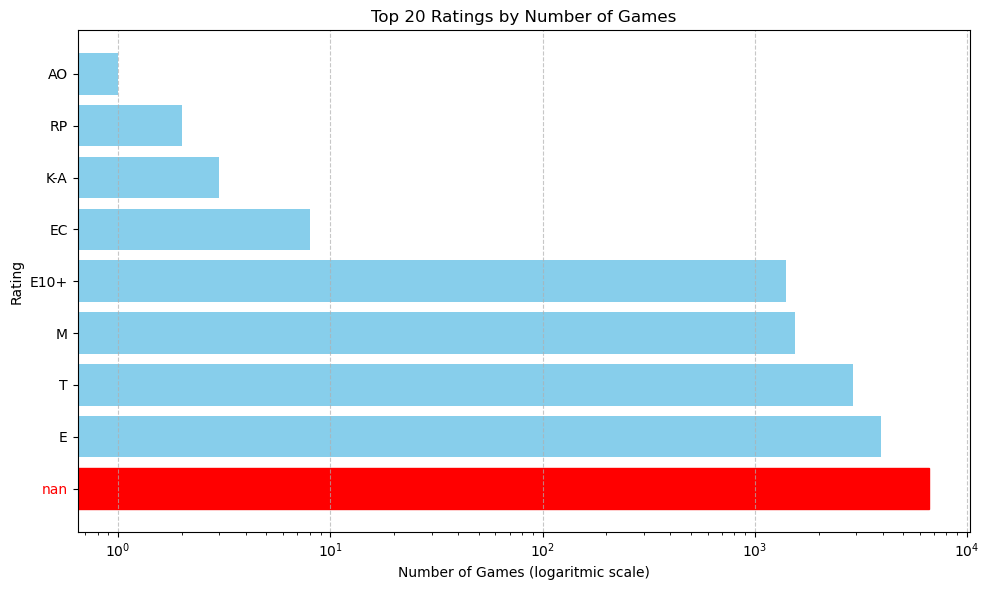

In [44]:
# conteggio dei giochi per ogni rating
rating_counts = dataset['Rating'].value_counts(dropna=False)
rating_labels = rating_counts.index.astype(str)
# creazione del grafico a barre
plt.figure(figsize=(10, 6))

bars = plt.barh(y=rating_labels, width=rating_counts.values,color= 'skyblue')

bars[0].set_color('red')
plt.gca().get_yticklabels()[0].set_color('red')


plt.title('Top 20 Ratings by Number of Games')
plt.xlabel('Number of Games (logaritmic scale)')
plt.xscale('log')
plt.ylabel('Rating')
plt.grid(axis='x', linestyle='--', alpha=0.7)  # griglia sull'asse x
plt.tight_layout()
plt.show()


Si nota immediatamente come la maggior parte dei valori siano mancanti mentre quelli presenti NON sono standardizzati.
questo perché il database contiene dati "internazionali", mentre il Rating dei videogiochi non segue regolamentazioni univoche, proponendo diverse "scale" in termini di classificazione e range d'età.

Proviamo a standardizzare il rating "a modo nostro" secondo la scala (numerica) PEGI, traformando la colonna in un tipo int per permetterci di fare operazioni aritmetiche.

É bene specificare che la "mappa" di conversione che produce la nostra scala di rating é approssimativa, poiché non esiste un metodo univoco e globalmente approvato per poter passare da una classificazione ad un altra.

In [45]:
PEGI_rating = {
    'AO': 17,
    'E': 3,
    'E10+': 7,
    'EC': None,  # non definito in PEGI
    'K-A': 3,    # K-A equivale a E, "Kids to Adults"
    'M': 17,
    'RP': None,  # non definito in PEGI
    'T': 12
}

dataset.loc[:,'Rating'] = dataset.loc[:,'Rating'].map(PEGI_rating)

# cast da string a int
dataset['Rating'] = pd.to_numeric(dataset['Rating'], errors='coerce').astype('Int64')

Utilizzando lo stesso ragionamento fatto in precedenza, per ogni tupla menomata cerco se c'é un gioco con lo stesso nome, ma con il rating definito.


In [46]:
null_count_before = dataset['Rating'].isnull().sum()

complete_column_with_same_name(dataset,'Rating')

print(f"Tuples fixed: {null_count_before-dataset['Rating'].isnull().sum()}")

Tuples fixed: 423


Inoltre, in modo analogo a quanto fatto per tentare di completare la colonna Year_of_Release, costruisco un OLAP avente come assi i valori di  Genre,Publisher,Rating

In [47]:
genre_labels = dataset.groupby('Genre').size().sort_values(ascending=False).index.to_numpy()
rating_labels = dataset['Rating'].dropna().sort_values(ascending=False).unique()

grouped_data = dataset.groupby(['Genre', 'Publisher','Rating']).size().reset_index(name='Count')

# restituisce mappe da stringa a indice
OLAP,genre_map,publisher_map,rating_map = create_OLAP(grouped_data,genre_labels,publisher_labels,rating_labels)

Visualizzo lo slicing lungo Publisher. 

Cerchiamo di trovare una correlazione tra la coppia (Genre,Publisher) e il valore Rating: vogliamo cioé dimostrare che un Publisher produce videogiochi con lo stesso Genre, solo per una fascia d'etá.

Purtroppo questa ipotesi si rivela FALSA.

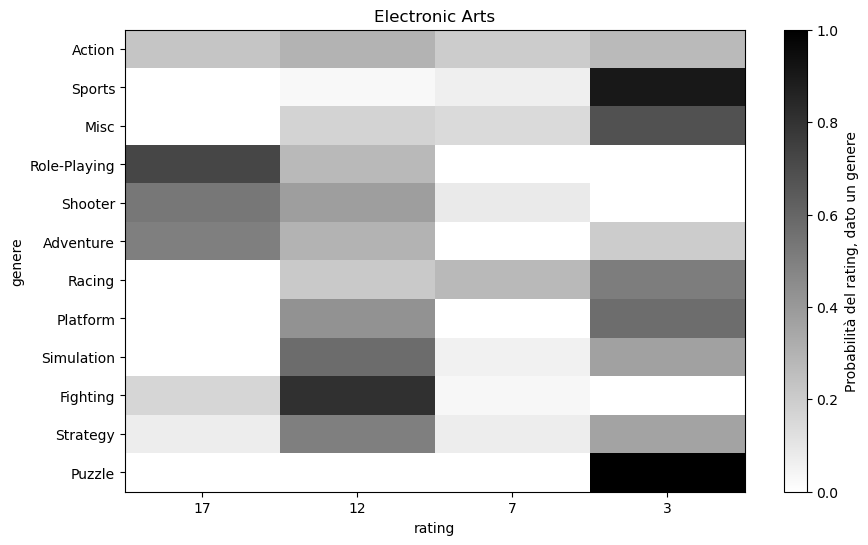

In [48]:
publisher_name = 'Electronic Arts'
publisher_id = publisher_map[publisher_name]
sliced_OLAP = OLAP[:,publisher_id,:]

# creazione della heatmap
plt.figure(figsize=(10, 6))
plt.imshow(sliced_OLAP / np.sum(sliced_OLAP, axis=1, keepdims=True), cmap='gray_r', aspect='auto') # normalizzo per genere

# etichette degli assi
plt.ylabel('genere')
plt.xlabel('rating')
plt.title(publisher_labels[publisher_id])
plt.colorbar(label='Probabilità del rating, dato un genere')

# aggiunta delle etichette delle piattaforme e degli anni
plt.xticks(range(len(rating_labels)), rating_labels)
plt.yticks(range(len(genre_labels)), genre_labels)

plt.show()

Nel nostro grafico abbiamo effettuato una normalizzazione per righe, speravamo di poter osservare per ognuna di esse una sola cella di colore nero:
questo si verifica ad esempio per il Genre Sports ma non per Action e molti altri.

Decidiamo quindi di scartare la colonna del Rating, in quanto non siamo stati in grado di trovare una correlazione con i dati in nostro possesso.

In [49]:
dataset = dataset.drop(columns=['Rating'])

### <p style="color:lightgreen;">DATASET PULITO </p>

Mostriamo infine il dataset pronto per essere studiato.

In [50]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16450 entries, 0 to 16718
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16450 non-null  object 
 1   Platform         16450 non-null  object 
 2   Year_of_Release  16450 non-null  int32  
 3   Genre            16450 non-null  object 
 4   Publisher        16450 non-null  object 
 5   NA_Sales         16450 non-null  float64
 6   EU_Sales         16450 non-null  float64
 7   JP_Sales         16450 non-null  float64
 8   Other_Sales      16450 non-null  float64
 9   Global_Sales     16450 non-null  float64
dtypes: float64(5), int32(1), object(4)
memory usage: 1.3+ MB


# <b style="color:tomato;"> VISUALIZZAZIONE DATI</b>

Utilizzando i dati (ripuliti) forniti, proviamo a studiare il mercato dei videogiochi: in particolare, cerchiamo di capire come questo sia profondamente eterogeneo nelle diverse regioni nel mondo.

## <p style="color:powderblue;"> CORRELAZIONI TRA MERCATI</p>

Mostriamo come le vendite nelle diverse regioni non siano correlate.

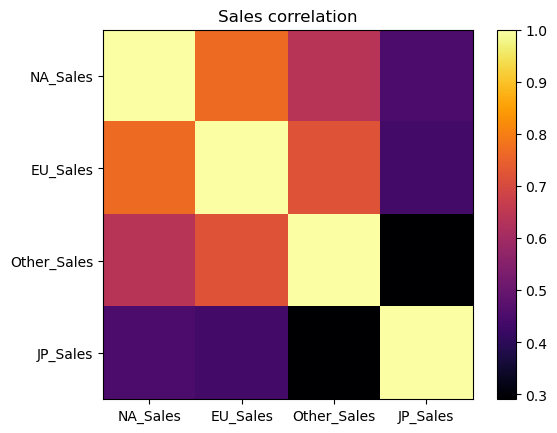

In [51]:
sales_labels = ['NA_Sales','EU_Sales','Other_Sales','JP_Sales']
correlations = dataset[sales_labels].corr()

plt.figure()
plt.imshow(correlations,origin='upper', cmap='inferno')
plt.colorbar()
plt.title('Sales correlation')
plt.xticks(range(len(sales_labels)), sales_labels)
plt.yticks(range(len(sales_labels)), sales_labels)
plt.show()

Possiamo osservare come i mercati di Europa e North America siano "simili", entrambi discostandosi leggermente da Other_Sales.

Il Giappone risulta però avere un mercato INDIPENDENTE dagli altri, avendo un valore di correlazione anch'esso sempre positivo, ma decisamente basso.

Mostriamo come i dati ottenuti vengano riflessi dall'osservazione empirica del dataset: 
ogni punto rappresenta una tupla, verde se ha maggiori vendite in giappone, rosso se inferiori e giallo se uguali.

I grafici sono posti in scala logaritmica e per completezza mostriamo anche il paragone con le vendite globali, colonna che (ovviamente) risulta sempre maggiore rispetto alle vendite in Giappone (é la somma delle vendite in tutte e 4 le localitá).

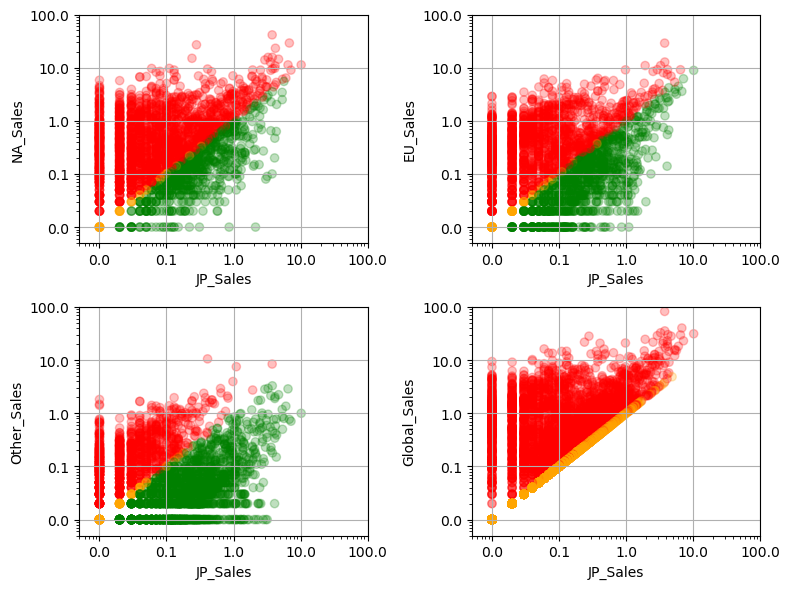

In [52]:
# lista delle etichette delle vendite
sales_labels = ['NA_Sales', 'EU_Sales', 'Other_Sales', 'Global_Sales']

# creazione dei 4 scatter plot
plt.figure(figsize=(8,6))

for i, sales_label in enumerate(sales_labels):
    ax = plt.subplot(2, 2, i + 1)
    x = dataset['JP_Sales']
    y = dataset[sales_label]
    colors = ['red' if x_val < y_val else 'green' if x_val > y_val else 'orange' for x_val, y_val in zip(x, y)]
    plt.scatter(x, y, alpha=0.25, color=colors)
    plt.xlabel('JP_Sales')
    plt.ylabel(sales_label)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim(0.005, 100)
    plt.ylim(0.005, 100)
    plt.gca().xaxis.set_major_formatter(ScalarFormatter(useOffset=False)) #cambio il formato da 10^2 a 100,...
    plt.gca().yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
    plt.grid(True)

plt.tight_layout()
plt.show()


Mettiamo a confronto l'andamento nel tempo delle vendite relative a ogni regione.

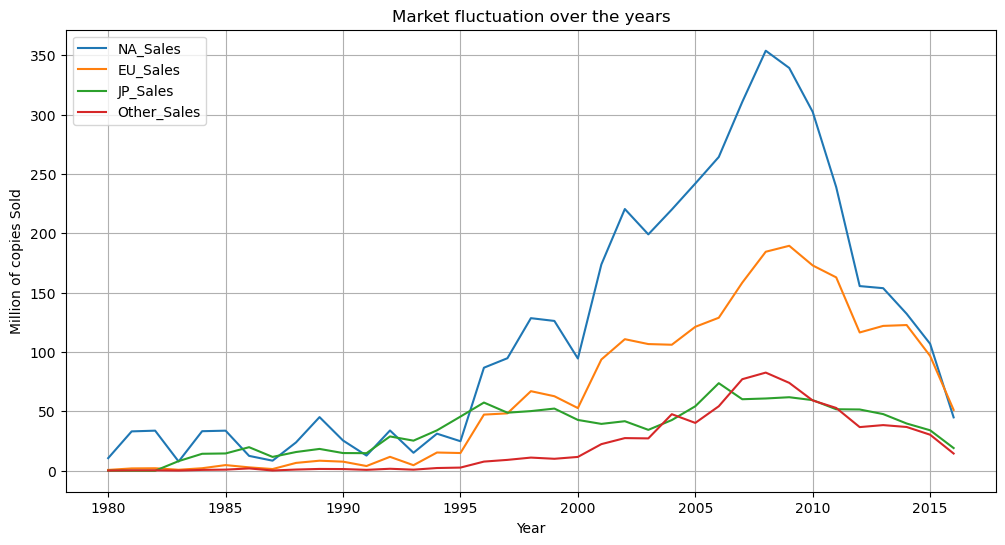

In [53]:
# gruppo dei dati per anno e somma delle vendite in ciascuna regione
sales_labels = ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']

sales_by_year = dataset.groupby('Year_of_Release')[sales_labels].sum()
all_years = sales_by_year.index # array che contiene tutti gli anni

# crea il primo grafico
plt.figure(figsize=(12, 6))

for label in sales_labels:
    plt.plot(all_years, sales_by_year[label], label=label)

# aggiungi titolo e label agli assi

plt.title('Market fluctuation over the years')
plt.xlabel('Year')
plt.ylabel('Million of copies Sold')
plt.legend(loc='upper left') 
plt.grid(True)


Come possiamo notare:
- NA_Sales e EU_Sales rimangono circa costanti per poi esplodere dal 1996 in poi.<br>
    Questo si puó attribuire alla presentazione di 2 console di nuova generazione, ovvero PS1 (nel 1994) e Nintendo64 (1996), che hanno permesso la transizione dalla grafica 2D a quella 3D. 
- JP_Sales invece, cresce fin da subito per poi rimanere circa stabile negli anni.<br>
    Possiamo individuare queste cause nella cultura videoludica fin da subita radicata, soprattutto dal fatto che i maggiori produttori di console e di videogiochi sono case nipponiche; ma anche per ragioni prettamente di marketing: spesso la data di uscita dei videogiochi e delle console (soprattutto in passato) non era globale, bensì caratterizzata da un'uscita anticipata proprio nei paesi asiatici.

É comunque necessario contestualizzare i dati mostrati, e comprendere come possano indurre a osservazioni che non rappresentano la realtá.

Ad esempio, negli ultimi anni possiamo notare un calo significativo del numero di copie vendute, ma questo puó essere motivato da una insieme di cause:
- I dati raccolti arrivano fino al 2017, e perció i giochi usciti negli anni direttamente antecedenti non hanno avuto il "tempo" di essere venduti.
- Il dataset considera solamente i giochi per Console fisiche prettamente dedicate ai videogiochi, mentre negli ultimi anni il mercato si é evoluto discostandosi molto da questa idea; basti pensare ai giochi per mobile o ai servizi di abbonamento di videogiochi (PS Plus,XboxGold, ...), i quali permettono di giocare un ampio catalogo di videogiochi senza aver effettivamente "comprato" alcuna copia.

# <b style="color:tomato"> STUDI PREDITTIVI </b>

Dopo aver meglio capito i dati su cui stiamo lavorando, possiamo finalmente chiederci se il movimento del mercato sia in qualche modo prevedibile.

Questa operazione risulta tutt'altro che banale, a causa delle limitate caratteristiche associate a ogni videogioco: per questo motivo ci limiteremo a cercare di predirre se un videogioco venderá meglio in europa o in giappone, in funzione di anno di rilascio, publisher, genere e piattaforma.

Aggiungiamo alcune colonne ausiliarie al nostro dataset: 
- "JP_better" -> valore di veritá di "JP_Sales >= EU_sales"
- "Year_of_Release_norm" -> valore numerico tra 1980 e 2017, mappato tra 0 e 1 
- "Genre_norm" -> associa ogni Genre a un valore tra 0 e 1 
- "Platform_norm" -> associa ogni Platform a un valore tra 0 e 1 
- "Publisher_norm" -> associa ogni Publisher a un valore tra 0 e 1 

In [54]:
# ordino i generi rispetto al più proficuo in giappone
genre_labels = dataset.groupby('Genre')['JP_Sales'].sum().sort_values(ascending=False).index.to_numpy() 
# publisher ordinati dal più al meno produttivo
publisher_labels = dataset.groupby('Publisher').size().sort_values(ascending=False).index.to_numpy() 
# piattaforme dalla più recente alla meno recente in media
platform_labels = dataset.groupby('Platform')['Year_of_Release'].mean().sort_values().index.to_numpy() 
# creo le mappe inverse
genre_map = create_map(genre_labels)
platform_map = create_map(platform_labels)
publisher_map = create_map(publisher_labels)

# iterazione su tutte le tuple
for index, row in dataset.iterrows():
    dataset.at[index,'JP_better'] = int(row['JP_Sales'] >= row['EU_Sales'])
    dataset.at[index,'Year_of_Release_norm'] = row['Year_of_Release']
    dataset.at[index,'Genre_norm'] = genre_map[row['Genre']]
    dataset.at[index,'Platform_norm'] = platform_map[row['Platform']]
    dataset.at[index,'Publisher_norm'] = publisher_map[row['Publisher']]
    
# normalizzo nel range 0,1
new_cols = ['Year_of_Release_norm','Genre_norm','Platform_norm','Publisher_norm']
scaler = MinMaxScaler()
dataset[new_cols] = scaler.fit_transform(dataset[new_cols])

## <p style="color:powderblue;"> REGRESSIONE LOGISTICA </p>

Introduciamo il <b style="color:orange">modello nullo</b>, ossia un modello predittivo costante sul valore più rappresentato (vittoria dell'EU):

In [55]:
pos = (dataset['JP_better'] == 0).sum()
tot = len(dataset)

print(f'Vittorie dell\'EU: {pos} su {tot}')
print(f'In percentuale: {pos/tot}')

Vittorie dell'EU: 9635 su 16450
In percentuale: 0.5857142857142857


Proseguiamo creando una <b style="color:orange">regressione logistica</b>, usando in input le informazioni su Platform, Genre, Year, Publisher:

In [56]:
#['Year_of_Release_norm','Genre_norm','Platform_norm','Publisher_norm']

X_train, X_test, Y_train, Y_test = train_test_split(dataset[new_cols], dataset['JP_better'], test_size=0.3,random_state=108889) # numero casuale, per poter riprodurre i risultati

# ottengo gli indici delle tuple su cui lavoro
ids_training = X_train.index
ids_testing = X_test.index

# faccio regressione logistica
clf = LogisticRegression()

clf.fit(X_train, Y_train)  # allena sui dati di training

train_results = clf.predict(X_train)
print('Training:', clf.score(X_train, Y_train))

test_results = clf.predict(X_test)
print('Validation:', clf.score(X_test, Y_test))

# aggiungo la colonna dei risultati ottenuti dalla predizione
dataset.loc[ids_training,'Prediction'] = train_results
dataset.loc[ids_testing,'Prediction'] = test_results

Training: 0.6019105514546244
Validation: 0.5973657548125634


Notiamo innanzitutto come la regressione logistica sia migliore del modello nullo seppur di un valore paragonabile all'1-2%. 

Un valore così "limitato" puó far pensare che sia solamente un caso che la nostra regressione sia migliore del modello nullo, ma anche eseguendo test con seed alternativi (che causano una diversa divisione in dati di training e di test) i valori risultano coerenti con quanto appena detto.

Analizziamo in forma matriciale i risultati ottenuti, in particolare cone le probabilità marginali:
$$ \begin{array}{c|c}
  B/A   & \text{Real Japan Win } (1) &  \text{Real EU Win } (0) & \text{Sum} \\ \hline
  \text{Prediction Japan Win } (1)  &  \blue{\boxed{1020}} & 776 & \orange{\boxed{1796}} \\
  \text{Prediction EU Win } (0) & 5795 & \blue{\boxed{8859}} & \orange{\boxed{14654}}\\
  \text{Sum} & \green{\boxed{6815}} & \green{\boxed{9635}} & 16450 \\
\end{array} $$
I risultati evidenziati $\blue{\blacksquare}$ sono quelli in cui la predizione è corretta.

Come possiamo vedere, mentre i risultati "reali" $\green{\blacksquare}$ sono abbastanza bilanciati, quelli della predizione $\orange{\blacksquare}$ sono completamente sbilanciati sulla vittoria dell'EU: in pratica la maggior parte degli errori é causata da un "undershooting" sui guadagni del giappone, ovvero "a priori" dice  praticamente sempre che un gioco performa meglio in Europa.

Questo ci dice quindi che non è una reale regressione, bensì nella maggior parte dei casi si prevede la vincita dell'EU "alla cieca", sapendo che realmente è proprio così (avvicinandoci molto al modello nullo).

In [57]:
images = save_plot_images(dataset,genre_labels,platform_labels,publisher_labels,plot_type='regression')

gif_name = '3d_regression.gif'
imageio.mimsave(gif_name, images,duration=300)


C:\Users\niniv\AppData\Local\Temp\ipykernel_10628\3290216515.py:76: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  for year in years: images.append(imageio.imread(f"{output_path}plot_{year}.png"))


Mostriamo ora in modo empirico quanto appena osservato.

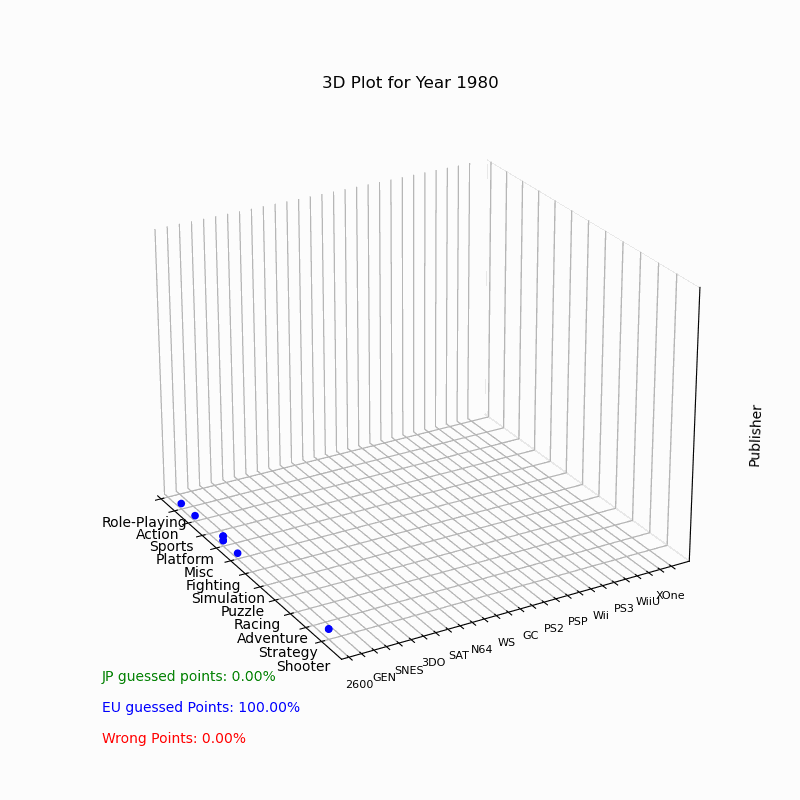

In [58]:
Image(filename=gif_name)

## <p style="color:powderblue;"> GRAFICI TEMPORALI </p>


Dopo aver osservato una completa inefficienza sul modello di regressione logistica, proviamo a visualizzare i dati in modi alternativo, cercando in modo empirico di poter osservare delle correlazioni tra i valori, per poter predire JP_better (ovvero cerchiamo di capire se il motivo del fallimento della regressione sia il modello o i dati in input).

Iniziamo dallo studio della variazione delle Platform nel tempo, confrontando il mercato EU e JP

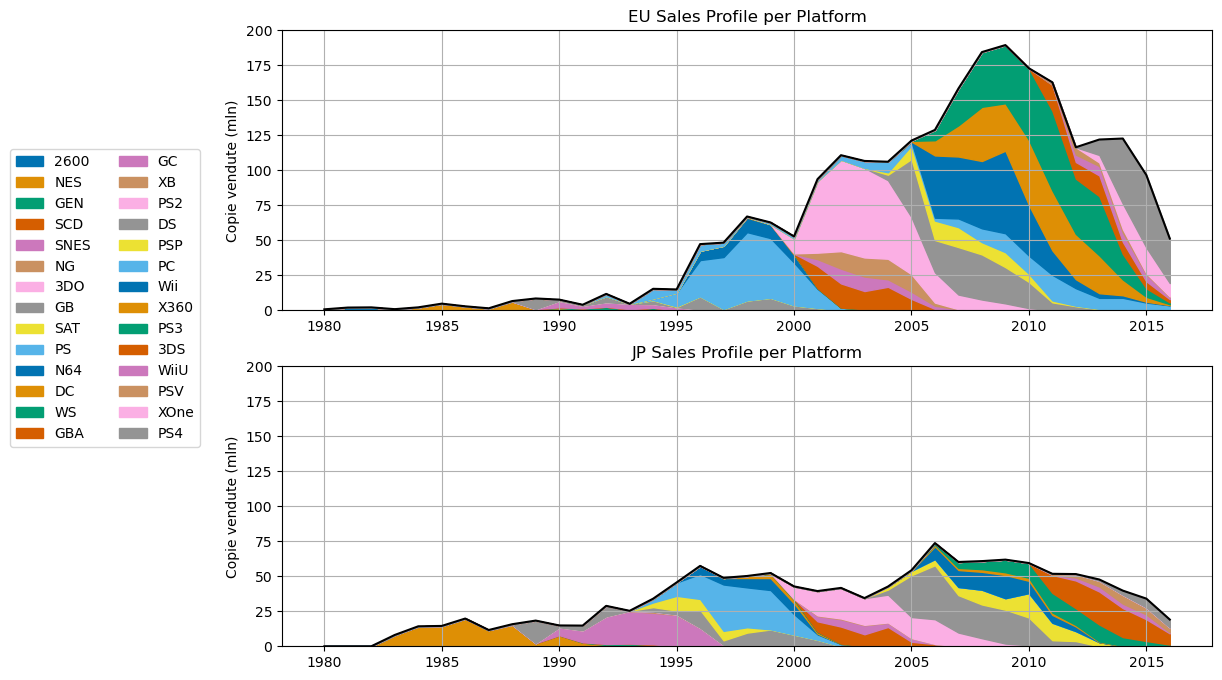

In [59]:
fig = plt.figure(figsize=(12, 8))
ax = plt.subplot(211)
draw_sales_profile(dataset, 'EU_Sales', 'Platform', position=(2, 1, 1), title='EU Sales Profile per Platform', resize_y=True)

ax = plt.subplot(212)
draw_sales_profile(dataset, 'JP_Sales', 'Platform', position=(2, 1, 2), title='JP Sales Profile per Platform', resize_y=True)

show_legend(ax, n=15, col=2)

plt.show()

Come già osservato in precedenza, i "picchi" sono spesso in concomitanza con l'uscita di una nuova console.

Possiamo dire qualcosa di più:
- Per quanto riguarda l'Europa, oltre al piccho del 1995-96 giá motivato, si nota un'altra crescita nel 2005 in cui vediamo "apparire" ben 3 console: Wii, X360 e PS3.
- É interessante vedere come questo trend non si possa osservare anche nel mercato nipponico: notiamo invece in esso la presenza del NES e SNES negli anni '90, ben prima che il mercato "esplodesse" anche in occidente.<br>
- Degno di nota é anche l'aumento delle vendite del 2004 in Giappone, anche se risulta avere cause che si discostano da quelle del picco in EU: infatti in Giappone ha venduto molto bene il Nintendo DS, mentre le console citate prima non hanno influito in un modo cosí marcato.<br>
- In maniera analoga il 3DS appare ben visibile nel mercato Giapponese, mentre in Europa assolutamente trascurabile.


Proseguiamo il nostro studio con i Generi.


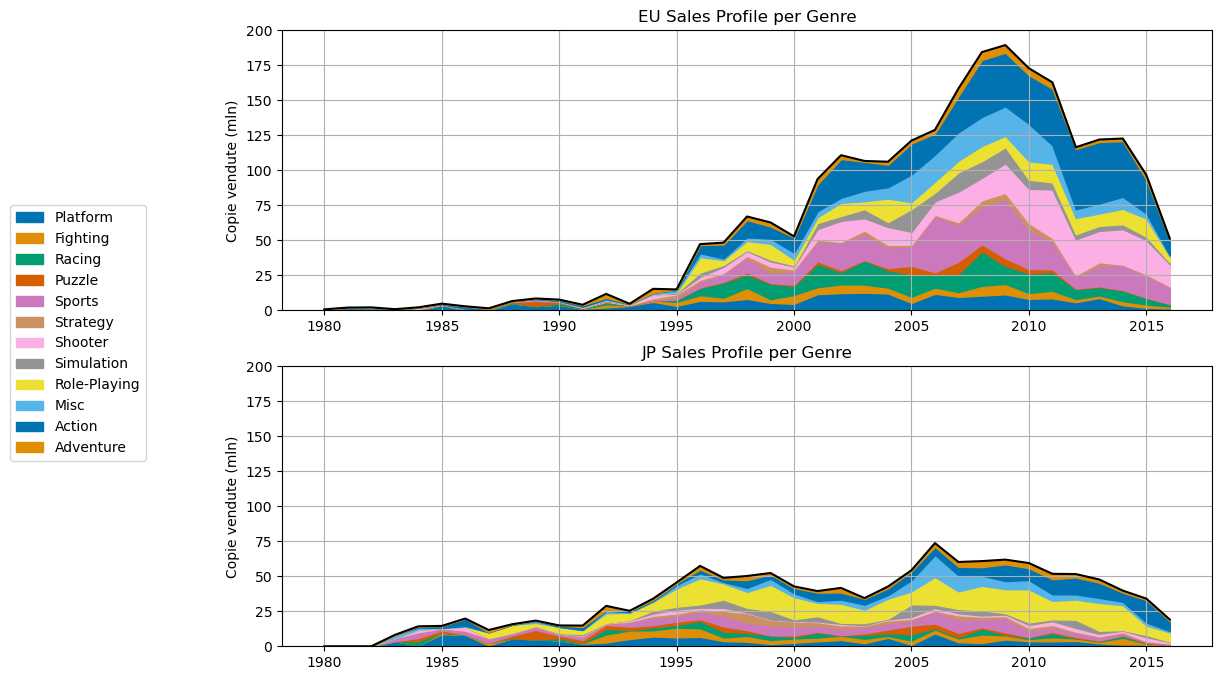

In [60]:
fig = plt.figure(figsize=(12, 8))
ax = plt.subplot(211)
draw_sales_profile(dataset, 'EU_Sales', 'Genre', position=(2, 1, 1), title='EU Sales Profile per Genre', resize_y=True)

ax = plt.subplot(212)
draw_sales_profile(dataset, 'JP_Sales', 'Genre', position=(2, 1, 2), title='JP Sales Profile per Genre', resize_y=True)

show_legend(ax, box_to_anchor=(-0.3, 1.6))

plt.show()

Anche in questo caso, possiamo vedere diverse discrepanze tra i 2 grafici, come ad esempio:
- In Europa vendono molto bene, rispetto al Giappone, i generi Action e Sports, con trend che costante negli anni.<br>
    Possiamo ovviamente motivare questa "costanza" del genere Sports con l'uscita di giochi annuali, come ad esempio FIFA, NBA o  Madden.

- In JP si nota immediatamente il genere Role-Playing, a cui sono attribuite saghe iconiche che si protraggono nel tempo: Pokemon primo su tutti, ma anche Final Fantasy.     


Concludiamo infine prendendo in considerazione i diversi Publisher di videogiochi.

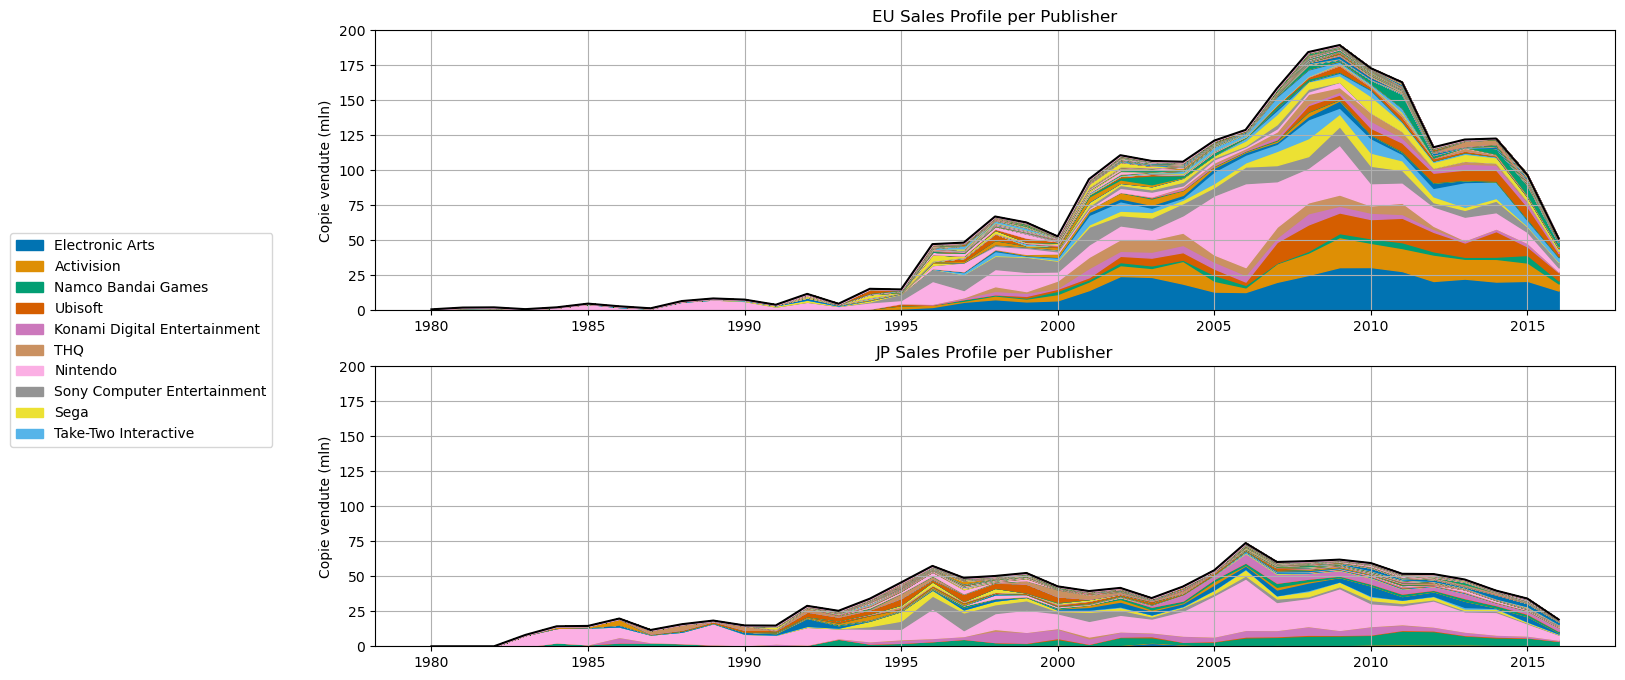

In [61]:
fig = plt.figure(figsize=(16, 8))
ax = plt.subplot(211)
draw_sales_profile(dataset, 'EU_Sales', 'Publisher', position=(2, 1, 1), title='EU Sales Profile per Publisher', resize_y=True)

ax = plt.subplot(212)
draw_sales_profile(dataset, 'JP_Sales', 'Publisher', position=(2, 1, 2), title='JP Sales Profile per Publisher', resize_y=True)

show_legend(ax, 10, box_to_anchor=(-0.3, 1.5))

plt.show()

Dopo le precedenti osservazioni, i grafici presentano semplicemente delle conferme su quanto detto:
- In Europa si distinguono Electronics Arts, che produce da sempre i giochi Sports accenanti prima, e Activision, punto di riferimento per i giochi Action e Shooter.
- La Nintendo é la fascia preponderante in Giappone (ma vende molto anche in Europa).
- "Namco Bandai Games" in Giappone vende di piú rispetto all'occidente; questo è in linea con quanto detto prima: le case nipponiche vengono molto bene a livello regionale.

Da questi grafici possiamo inoltre osservare come le informazioni sui Publisher e sulle Platform siano profondamente correlate...

Per quanto riguarda la Nintendo il mercato su di essa risulta un monopolio, ovvero rappresenta una "nicchia". <br>
Possiamo infatti osservare come i picchi della Nintendo del 2006 e del 2009, siano perfettamente coerenti con l'uscita di nuove console da loro direttamente prodotte.


## <p style="color:powderblue;"> NOSTRA REGRESSIONE </p>

Dopo aver osservato in modo empirico queste differenze tra i 2 mercati, facciamo ora un piccolo "test" per mostrare come la regressione effettuata prima fosse di scarso valore.

Questo risultato era giá stato confermato dall'estrema vicinanza al MODELLO NULLO, ma questo non ci dá informazioni sull'effettiva esistenza di metodo predittivi migliori.

Il nostro scopo é proprio quello di "comporre" una predizione, per andarla poi a paragonare a quella effettuata in precedenza.<br>
Iniziamo dicendo che tutti i videogiochi vendono meglio in Europa, salvo 3 eccezioni (ricavate una da ogni grafico):
- I giochi per il DS
- I giochi con genere 'Role-Playing'
- I giochi sviluppati da 'Namco Bandai Games'

In [62]:
# inizializzo la colonna 'My_prediction' con zeri
dataset['My_prediction'] = np.zeros(len(dataset))
id_column = dataset.columns.get_loc('My_prediction')

# imposto a 1 i valori della colonna 'My_prediction' dove 'Platform' è 'DS'
nes_ids = np.where(dataset['Platform'] == 'DS')[0]
dataset.iloc[nes_ids, id_column] = 1

# imposto a 1 i valori della colonna 'My_prediction' dove 'Genre' è 'Role-Playing'
role_playing_ids = np.where(dataset['Genre'] == 'Role-Playing')[0]
dataset.iloc[role_playing_ids, id_column] = 1

# imposto a 1 i valori della colonna 'My_prediction' dove 'Publisher' è 'Namco Bandai Games'
nintendo_ids = np.where(dataset['Publisher'] == 'Namco Bandai Games')[0]
dataset.iloc[nintendo_ids, id_column] = 1

# calcolo l'accuratezza della predizione rispetto alla colonna 'JP_better'
accuracy = np.mean(dataset['My_prediction'] == dataset['JP_better'])
print("Accuracy:", accuracy)

Accuracy: 0.6767173252279636


Notiamo un incremento del 5% sulla predizione, ma vogliamo inoltre studiare meglio come sono variati i valori all'interno della matrice.

Regressione Logistica:
$$ \begin{array}{c|c}
  B/A   & \text{Real Japan Win } (1) &  \text{Real EU Win } (0) & \text{Sum} \\ \hline
  \text{Prediction Japan Win } (1)  &  \orange{\boxed{1020}} & 776 & \red{\boxed{1796}} \\
  \text{Prediction EU Win } (0) & 5795 & \orange{\boxed{8859}} & \red{\boxed{14654}}\\
  \text{Sum} & 6815 & 9635 & 16450 \\
\end{array} $$

My_prediction:
$$ \begin{array}{c|c}
  B/A   & \text{Real Japan Win } (1) &  \text{Real EU Win } (0) & \text{Sum} \\ \hline
  \text{Prediction Japan Win } (1)  &  \blue{\boxed{2785}} & 1288 & \green{\boxed{4073}} \\
  \text{Prediction EU Win } (0) & 4030 & \blue{\boxed{8347}} & \green{\boxed{12.377}}\\
  \text{Sum} & 6815 & 9635 & 16450 \\
\end{array} $$


La principale differenza che possiamo vedere é come i valori nei riquadri $\green{\blacksquare}$ siano piú simili ai valori attesi, ovvero abbiamo avuto un maggiore "bilanciamento" delle predizioni, rispetto al modello automatico.

Questo modello "alternativo" NON vuole assolutamente pretendere di essere un "buon modello", in quanto ha una percentuale di successo del 67%.<br>
Ha solamente lo scopo di mostrare come a volte, anche se i dati forniti non hanno correlazioni facilmente "visibili" in modo algoritmico, spesso la conoscenza a priori del dominio applicativo puó fornire risultati migliori, con uno sforzo molto piú limitato (3 condizioni if messe in sequenza, per ogni tupla).

# <b style="color:tomato"> SEGMENTAZIONE DEL MERCATO</b>

Identifichiamo le caratteristiche comuni tra i videogiochi che tendono a ottenere risultati di vendita simili nei diversi mercati globali,principalmente andando a formare cluster di videogiochi con performance di vendita omogenea, paragonandole con i pattern che abbiamo giá osservato.

## <p style="color:powderblue;"> TEST DEL CHI-QUADRATO DI INDIPENDENZA </p>

Mostriamo prima di tutto un'indipendenza tra le colonne che descrivono l'anno di uscita e il Genere dei videogiochi.<br>
Utilizziamo il test del chi-quadrato per ottenere uno studio statistico che con "abbastanza" certezza ci descrive questa correlazione.


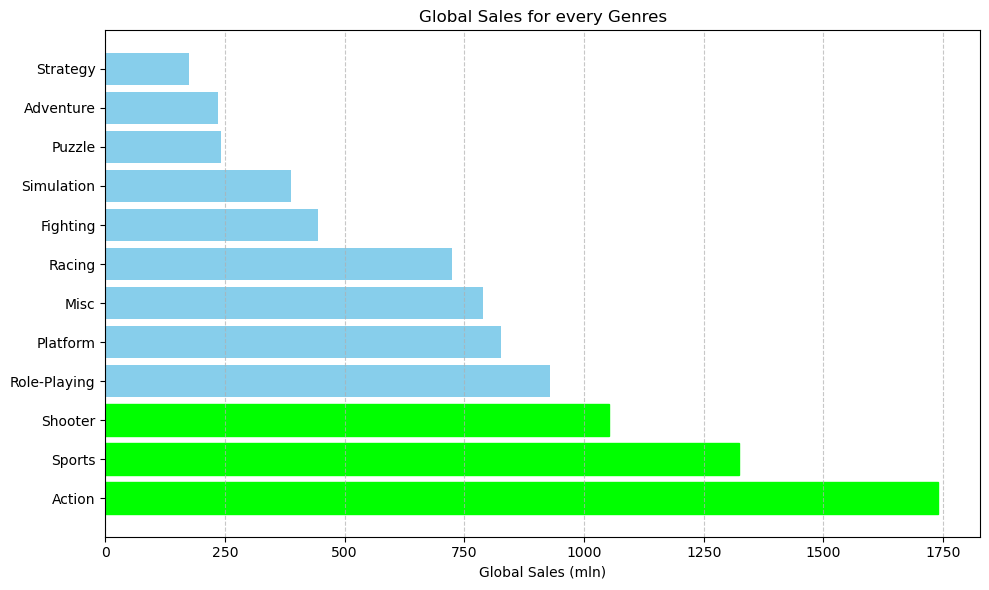

In [63]:
# giochi più venduti per ogni genere
plt.figure(figsize=(10, 6))
top_genres = dataset.groupby('Genre')['Global_Sales'].sum().sort_values(ascending=False)
bars = plt.barh(y=top_genres.index, width=top_genres.values,color= 'skyblue')

bars[0].set_color('lime')
bars[1].set_color('lime')
bars[2].set_color('lime')

plt.title('Global Sales for every Genres')
plt.xlabel('Global Sales (mln)')
plt.grid(axis='x', linestyle='--', alpha=0.7) 
plt.tight_layout()
plt.show()

Data la forte eterogeneitá dei dati forniti, ovvero 12 Genres X 37 Years, andiamo a scegliere solo alcuni valori tra questi.

In particolare scegliamo solamente i Generi piú "presenti" sul mercato (Action, Sports, Shooter).

In [64]:
# quantizzo l'anno di uscita in 5 fasce
selected_years = pd.cut(dataset['Year_of_Release'], bins=5, labels=False)
# scelgo solo i generi "top 3" (Shooter, Sports e Action)
selected_genres = dataset['Genre'].isin(['Shooter','Sports','Action'])
# creazione della tabella di contingenza con gli anni quantizzati sulle righe e i generi selezionati sulle colonne
sales_table = pd.crosstab(selected_genres, selected_years)

# esecuzione del test del chi-quadro
chi2, p_value, dof, expected = chi2_contingency(sales_table)

np.set_printoptions(suppress=True)

print("Risultati del test del Chi-Quadro:")
print("Chi-Quadro:", chi2)
print("Livello di significatività:", 0.05)
print("p-value:", f"{p_value:.30f}")
print("Gradi di libertà:", dof)
print("Tabella attesa:")
print(expected)

Risultati del test del Chi-Quadro:
Chi-Quadro: 105.3266970178554
Livello di significatività: 0.05
p-value: 0.000000000000000000000721566085
Gradi di libertà: 4
Tabella attesa:
[[ 106.70395137  181.10832827 1335.8181155  4019.56668693 3844.80291793]
 [  78.29604863  132.89167173  980.1818845  2949.43331307 2821.19708207]]


Risultato abbastanza aspettato:
- il p-value è estremamente basso, il che ci dice che praticamente non abbiamo possibilità di ottenere risultati tanto diversi usando un altro campione delle stesse dimensioni
- il valore Chi-Quadro ottenuto è nettamente superiore a quello riportato nella corrispondente cella della tabella dei valori critici

Quindi rifiutiamo l'ipotesi nulla -> le variabili NON sono indipendenti

## <p style="color:powderblue;"> CLUSTERING</p>

Proponiamo ora un approccio "alternativo" allo studio del mercato: proviamo a clusterizzare in uno spazio tridimensionale che utilizza come assi i valori delle vendite in Europa, Nord America e Giappone.

É necessario, per poter clusterizzare, che gli assi siano in "scale" compatibili tra loro; nonostante questo si verifichi già, portiamo tutto in scala logaritmica e ci limitiamo a prendere i valori compresi dall'1 al 99 percentile.

Questo procedimento ci serve per ovviare al problema che i nostri dati presentano moltissimi giochi con vendite minime (inferiori a 0.1 milioni, mentre gli outliers hanno valori completamente "fuori scala").

In [65]:
# creo nuove colonne che uso per lo studio, sono le vendite ma in scala logaritmica (migliora il clustering)
labels = ["EU_Sales", "Other_Sales","NA_Sales"]
new_cols = ["EU_Sales_norm", "Other_Sales_norm","NA_Sales_norm"]

# rendo tutto logaritmico
dataset[new_cols] = np.log1p(dataset[labels])

# tolgo outliers c
perc_cut = 0.001
for col in new_cols:
    lower_bound = dataset[col].quantile(perc_cut)
    upper_bound = dataset[col].quantile(1-perc_cut)
    dataset[col] = dataset[col].clip(lower=lower_bound, upper=upper_bound)



Mettiamo a confronto la "bontá" di grafici con un diverso numero di cluster: 
-   Utilizziamo il "metodo del gomito" per il primo grafico, ovvero dobbiamo andare a cercare il punto il cui abbiamo un cambio maggiore di inclinazione.
-   Utilizziamo il "silhouette_score" per il secondo grafico, e in teoria dorevmmo andare a prendere il punto di massimo (dati ottimali mostrerebbero un grafico paragonabile a una gaussiana).

Dal punto di vista teorico, questi 2 risultati dovrebbero essere "allineati" e "suggerire" lo stesso numero di cluster.

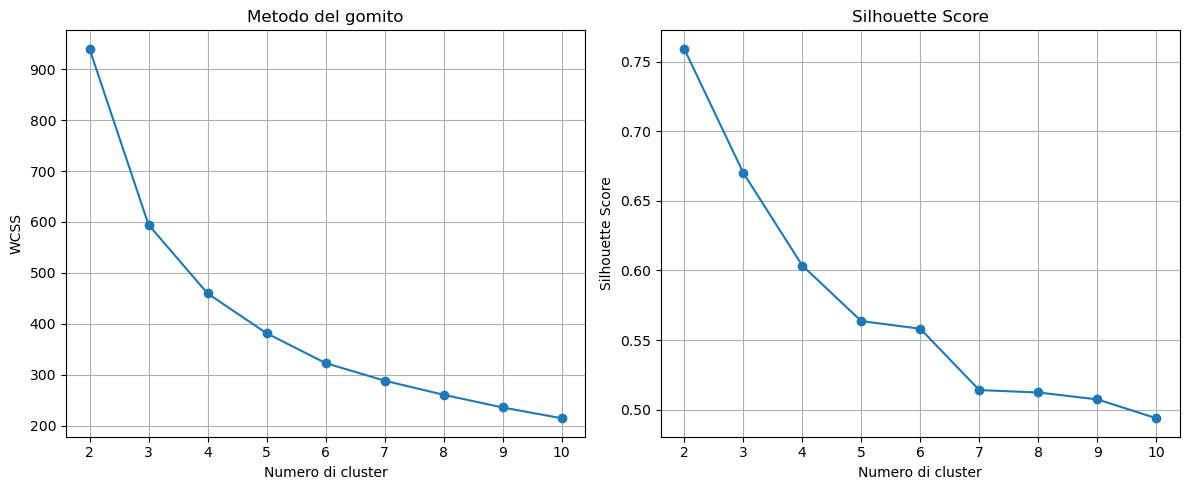

In [66]:
X = dataset[new_cols]
# lista per salvare i valori del metodo del gomito (WCSS) e della silhouette
elbow_values = []
silhouette_scores = []

# calcolo il metodo del gomito e la silhouette per un range di numeri di cluster
for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=100, n_init=10, random_state=0)
    cluster_labels = kmeans.fit_predict(X)
    
    elbow_values.append(kmeans.inertia_)  # aggiungo il valore del WCSS
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_scores.append(silhouette_avg)  # aggiungo il punteggio della silhouette

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# plot del metodo del gomito
axs[0].plot(range(2, 11), elbow_values, marker='o')
axs[0].set_title('Metodo del gomito')
axs[0].set_xlabel('Numero di cluster')
axs[0].set_ylabel('WCSS')
axs[0].grid(True)

# plot della silhouette
axs[1].plot(range(2, 11), silhouette_scores, marker='o')
axs[1].set_title('Silhouette Score')
axs[1].set_xlabel('Numero di cluster')
axs[1].set_ylabel('Silhouette Score')
axs[1].grid(True)

plt.tight_layout() 
plt.show()


Possiamo notare come ambo i metodi non diano risultati "interpretabili", e perció in modo arbitrario decidiamo di utilizzare 3 cluster.

In [67]:
k = 3
clusters_array = KMeans(init='k-means++',n_clusters= k, max_iter=100,random_state=0).fit_predict(X) 
dataset['Cluster_number'] = clusters_array 

Plottiamo il grafico prodotto, utilizzando un colore diverso per ogni cluster.

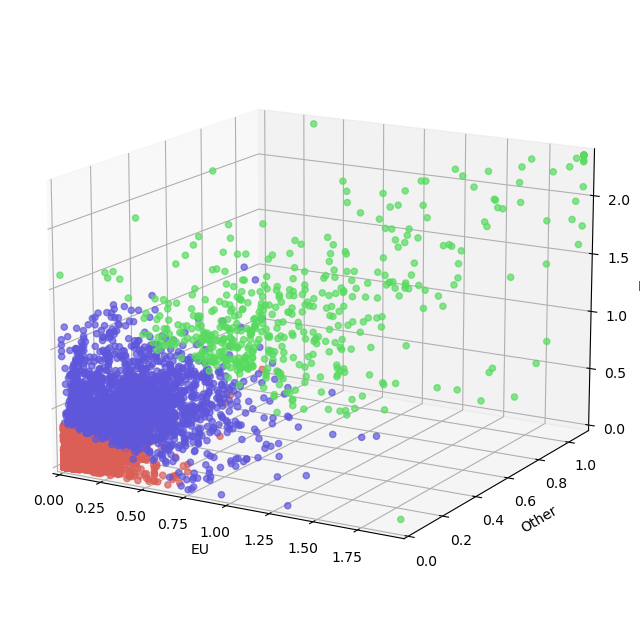

In [68]:

# inizializzazione del grafico 3D
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

# plot dei dati
palette = sns.color_palette('hls',n_colors=k)
ax.scatter(dataset["EU_Sales_norm"], dataset["Other_Sales_norm"], dataset["NA_Sales_norm"], alpha=0.7,color= [palette[i] for i in dataset['Cluster_number']])

# etichette degli assi
ax.set_xlabel('EU')
ax.set_ylabel('Other')
ax.set_zlabel('NA')

ax.set_xlim(0,dataset["EU_Sales_norm"].max())
ax.set_ylim(0,dataset["Other_Sales_norm"].max())
ax.set_zlim(0,dataset["NA_Sales_norm"].max())

ax.view_init(elev=15, azim=300)  # modifica i valori di elev e azim 

plt.show()


Possiamo osservare come i videogiochi rossi siano quelli piú "densi", mentre invece quelli verdi sono piú "sparsi": questo perché i videogiochi che tendono a vendere poco in una regione vendono poco in tutte le altre, mentre per i videogiochi che hanno un successo piú marcato la correlazione non é immediata.

Concludiamo lo studio mostrando come questi cluster si possano mettere in relazione con le colonne restanti, ovvero Genres, Platform, Publisher, Year_of_Release: intuitivamente, stiamo cercando di trovare dei pattern ricorrenti che portino un videogioco a essere in porzioni (cluster) ben definiti del mercato.

In [69]:
images = save_plot_images(dataset,genre_labels,platform_labels,publisher_labels,plot_type='clustering',palette=palette)
gif_file = "3d_clustering.gif"
imageio.mimsave(gif_file, images,duration=300)

C:\Users\niniv\AppData\Local\Temp\ipykernel_10628\3290216515.py:76: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  for year in years: images.append(imageio.imread(f"{output_path}plot_{year}.png"))


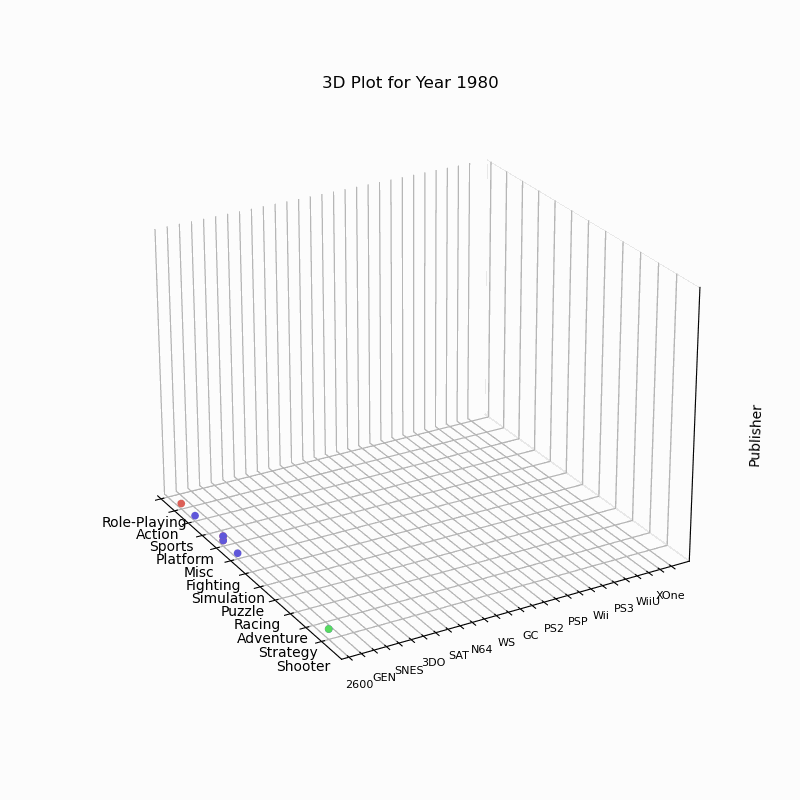

In [70]:
Image(filename=gif_file)

Interpretando i dati ottenuti, notiamo come:
- i valori rossi, che sono in quantità nettamente maggiore ed erano semplicemente addensati nel grafico precedente, sono principalmente prodotti da Publisher meno conosciuti (come viene ovvio pensare, altrimenti avrebbero successo e produrrebbero molti altri videogiochi).
- i blu sono un cluster "intermedio"
- i verdi sono quasi tutti posizionati "in basso"; ovvero sono caratterizzati sia dall'essere molto venduti che pubblicati da publisher tendenzialmente di successo.